<h4>ChatGPT Internal Source Consistency Analysis</h4>
<p>
This notebook evaluates ChatGPT’s internal consistency in source citation behavior. Each query was executed three independent times using the ChatGPT web interface. Each query thus contributes three independent source lists.
</p>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "src")))
from data import get_chatgpt_df
from metrics import syntactic_overlap, extrapolated_rbo
from plots import boxplot, heatmaps

In [2]:
OVERLAP_FUNCTION = extrapolated_rbo

<h4>Dataset: ChatGPT</h4>

In [3]:
chatgpt_df = get_chatgpt_df()
chatgpt_df

,query,product,market_type,query_level,response_text,sources_cited,sources_additional,sources_all,domains_cited,domains_additional,domains_all,recommended_products
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,[There’s no one “best” smartphone that’s perfe...,[[https://www.tomsguide.com/best-picks/best-ph...,[[https://www.tomsguide.com/phones/android-pho...,[[https://www.tomsguide.com/best-picks/best-ph...,"[[tomsguide.com, forbes.com], [tomsguide.com],...","[[reddit.com, tomsguide.com, techrepublic.com,...","[[tomsguide.com, forbes.com, reddit.com, techr...","[[Apple iPhone 17 Pro Max, Samsung Galaxy S25 ..."
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,"[There’s no one “best” smartphone under $1,000...",[[https://www.tomsguide.com/best-picks/best-ph...,[[https://www.androidcentral.com/best-android-...,[[https://www.tomsguide.com/best-picks/best-ph...,"[[tomsguide.com, phonearena.com, wired.com], [...","[[reddit.com, theverge.com, techadvisor.com, w...","[[tomsguide.com, phonearena.com, wired.com, re...","[[Samsung Galaxy S25, Samsung Galaxy S25+, App..."
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,"[There’s no one-size-fits-all “best” phone, be...",[[https://www.techradar.com/news/best-cameraph...,[[https://coffeechoice.org/en/best-smartphones...,[[https://www.techradar.com/news/best-cameraph...,"[[tomsguide.com, techradar.com], [abdgadgets.c...","[[reddit.com, tomsguide.com, stuff.tv, techadv...","[[tomsguide.com, techradar.com, reddit.com, st...","[[Apple iPhone 16 Pro, Samsung Galaxy S25 Ultr..."
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,[That’s a great question — the “best” depends ...,[[https://www.androidcentral.com/phones/oneplu...,[[https://www.techadvisor.com/article/723383/b...,[[https://www.androidcentral.com/phones/oneplu...,"[[androidcentral.com, tomsguide.com, phonearen...","[[tomsguide.com, wired.com, co.uk, 9to5google....","[[androidcentral.com, tomsguide.com, phonearen...","[[OnePlus 13, Samsung Galaxy S25, Google Pixel..."
4,What is the best laptop?,Laptop,Commodity / Saturated,General,[There’s no one-size-fits-all “best laptop” — ...,[[https://www.pcworld.com/article/436674/best-...,[[https://www.bleepingcomputer.com/forums/t/81...,[[https://www.pcworld.com/article/436674/best-...,"[[windowscentral.com, rtings.com, pcworld.com,...","[[reddit.com, bestbuy.com, windowscentral.com,...","[[windowscentral.com, rtings.com, pcworld.com,...","[[Lenovo Yoga 9i 2-in-1 Aura Edition, Lenovo T..."
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,[There’s no one-size-fits-all “best” laptop un...,[[https://www.tomshardware.com/best-picks/best...,[[https://www.laptopmag.com/articles/best-lapt...,[[https://www.tomshardware.com/best-picks/best...,"[[tomshardware.com, wired.com], [tomshardware....","[[reddit.com, tomshardware.com, pcworld.com, y...","[[tomshardware.com, wired.com, reddit.com, pcw...","[[HP Victus 16, Asus Zenbook S 16, MacBook Air..."
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,[“Best” depends a lot on what you plan to use ...,[[https://www.tomshardware.com/best-picks/best...,[[https://www.laptopmag.com/articles/best-lapt...,[[https://www.tomshardware.com/best-picks/best...,"[[tomshardware.com, techradar.com], [tomshardw...","[[reddit.com, tomsguide.com, tomshardware.com,...","[[tomshardware.com, techradar.com, reddit.com,...","[[HP Victus 16, Apple MacBook Air 15″ (M4), HP..."
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,[“Best” always depends a bit on what you value...,[[https://www.ultrabookreview.com/2071-best-ga...,[[https://www.pcworld.com/article/436674/best-...,[[https://www.ultrabookreview.com/2071-best-

<h4>Mean Internal Source Overlap - Definition & Implementation</h4> 
<p>To evaluate how consistent ChatGPT is in the sources it cites across multiple runs of the same query, we define the Mean Internal Source Overlap (MISO). This metric captures, on average, how much the sets of retrieved or cited sources overlap syntactically between runs, providing a way to measure the stability of ChatGPT’s information retrieval process.</p>

<p>
Formally, let \( C = \{(i, j) \mid 1 \le i < j \le |S_{GPT_q}|\} \) denote the set of all unique pairs of source lists for query \( q \), such that \( |C| = \binom{|S_{GPT_q}|}{2} \). 
Then, the Mean Internal Source Overlap is defined as:
</p> 

<p style="text-align:center;"> 
\( MISO(q) = \frac{1}{|C|} \sum_{(i, j) \in C} O_{\text{syntactic}}(s_{qi}, s_{qj}) \) 
</p> 

<p>
where \( O_{\text{syntactic}}(s_{qi}, s_{qj}) \) represents the syntactic overlap between the two source lists \( s_{qi} \) and \( s_{qj} \). This coefficient captures the proportion of shared sources relative to the smaller of the two lists, making it robust to list length differences. Higher MISO values indicate greater internal consistency in ChatGPT’s source selection, reflecting stable retrieval behavior across independent runs of the same query.
</p>

In [4]:
def calc_miso(chatgpt_df, chatgpt_sources, overlap_function):
    from itertools import combinations
    
    mipo_results = []

    for _, row in chatgpt_df.iterrows():
        row_list = row[chatgpt_sources]
        pairwise_scores = []

        for c in combinations(row_list, 2):
            score = overlap_function(c[0], c[1])
            pairwise_scores.append(score)

        syntactic_mean = np.mean(pairwise_scores)
        syntactic_var = np.var(pairwise_scores, ddof = 0)
        syntactic_std = np.sqrt(syntactic_var)

        mipo_results.append({
            "query": row["query"],
            "product": row["product"],
            "market_type": row["market_type"],
            "query_level": row["query_level"],
            "miso_mean": syntactic_mean,
            "miso_var": syntactic_var,
            "miso_std": syntactic_std
        })

    return pd.DataFrame(mipo_results)

<h4>Mean Internal Source Overlap - Cited Sources Analysis</h4>

In [5]:
miso_df_cs = calc_miso(chatgpt_df, chatgpt_sources = "sources_cited", overlap_function = OVERLAP_FUNCTION)
miso_df_cs

,query,product,market_type,query_level,miso_mean,miso_var,miso_std
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,0.900200,0.000211,0.014535
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,0.248583,0.123587,0.351550
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,0.271200,0.147099,0.383535
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,0.000000,0.000000,0.000000
4,What is the best laptop?,Laptop,Commodity / Saturated,General,0.601813,0.002064,0.045430
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,0.550000,0.000000,0.000000
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,0.701350,0.023889,0.154559
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,0.135600,0.036775,0.191767
8,What is the best smartwatch?,Smartwatch,Commodity / Saturated,General,0.554550,0.015699,0.125297
9,What is the best smartwatch under 800 dollars?,Smartwatch,Commodity / Saturated,General & Price,0.781321,0.012813,0.113195


<h4>Mean Internal Source Overlap - Analysis (Cited Sources)</h4>

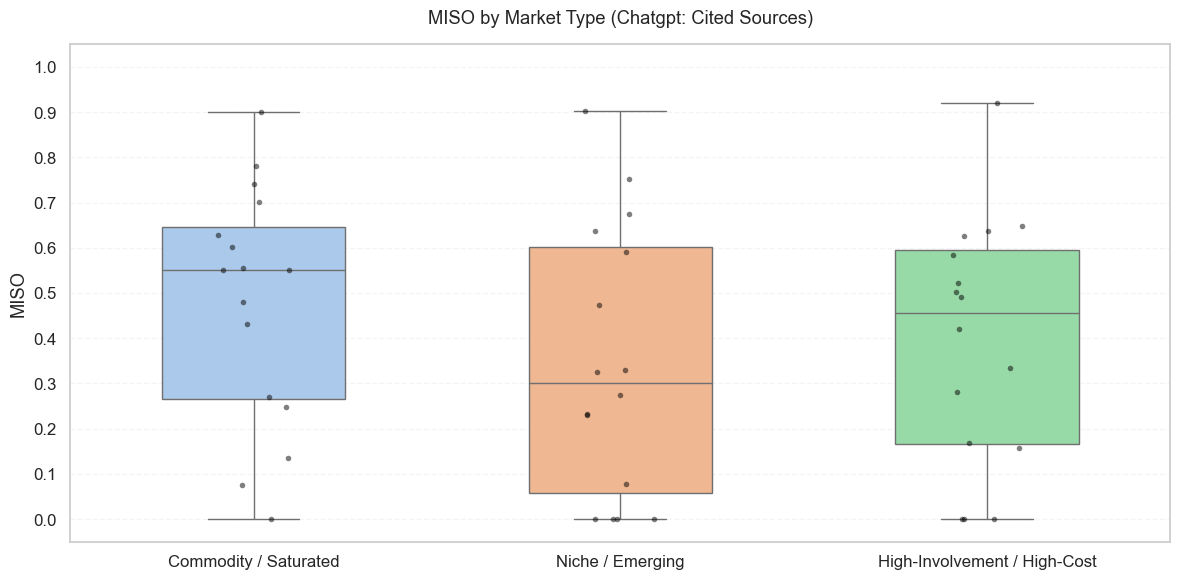

In [6]:
miso_cs_cs = miso_df_cs[miso_df_cs["market_type"] == "Commodity / Saturated"]
miso_ne_cs = miso_df_cs[miso_df_cs["market_type"] == "Niche / Emerging"]
miso_hh_cs = miso_df_cs[miso_df_cs["market_type"] == "High-Involvement / High-Cost"]

plot_df_cs = pd.DataFrame({
    "MISO": pd.concat([
        miso_cs_cs["miso_mean"],
        miso_ne_cs["miso_mean"],
        miso_hh_cs["miso_mean"],
    ], ignore_index = True),
    "Market Type": (
        ["Commodity / Saturated"] * len(miso_cs_cs)
        + ["Niche / Emerging"] * len(miso_ne_cs)
        + ["High-Involvement / High-Cost"] * len(miso_hh_cs)
    )
})

boxplot(
    df = plot_df_cs,
    x_col = "Market Type",
    y_col = "MISO",
    order = ["Commodity / Saturated", "Niche / Emerging", "High-Involvement / High-Cost"],
    title = "MISO by Market Type (Chatgpt: Cited Sources)",
    xlabel = "",
    ylabel = "MISO"
)

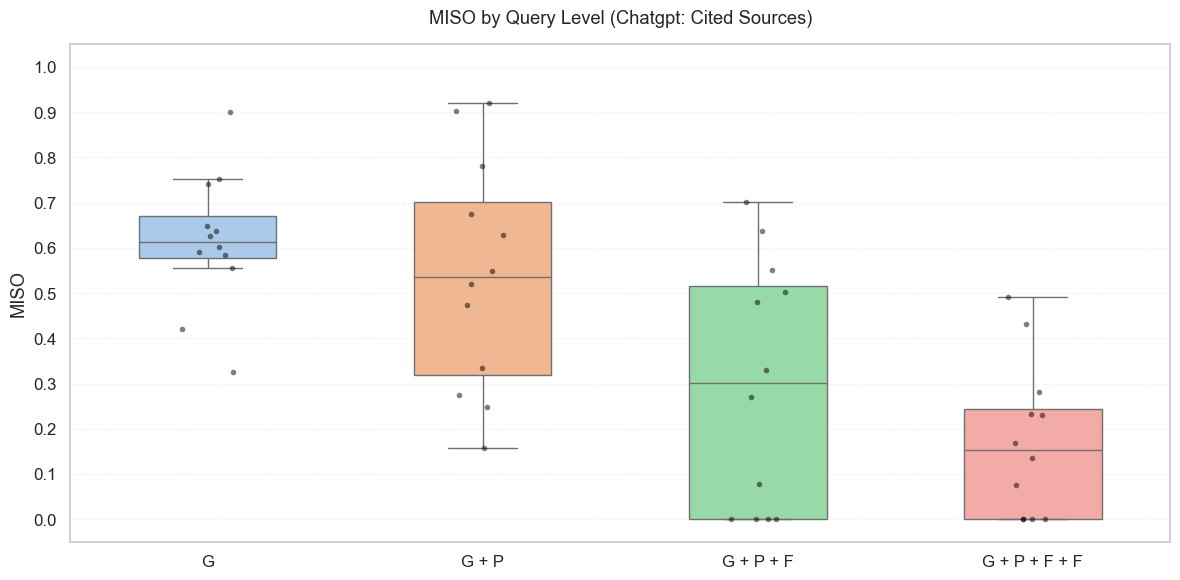

In [7]:
miso_g_cs = miso_df_cs[miso_df_cs["query_level"] == "General"]
miso_gp_cs = miso_df_cs[miso_df_cs["query_level"] == "General & Price"]
miso_gpf_cs = miso_df_cs[miso_df_cs["query_level"] == "General & Price & Feature"]
miso_gpff_cs = miso_df_cs[miso_df_cs["query_level"] == "General & Price & Feature & Feature"]

plot_df_cs = pd.DataFrame({
    "MISO": pd.concat([
        miso_g_cs["miso_mean"],
        miso_gp_cs["miso_mean"],
        miso_gpf_cs["miso_mean"],
        miso_gpff_cs["miso_mean"]
    ], ignore_index = True),
    "Query Level": (
        ["G"] * len(miso_g_cs)
        + ["G + P"] * len(miso_gp_cs)
        + ["G + P + F"] * len(miso_gpf_cs)
        + ["G + P + F + F"] * len(miso_gpff_cs)
    )
})

boxplot(
    df = plot_df_cs,
    x_col = "Query Level",
    y_col = "MISO",
    order = ["G", "G + P", "G + P + F", "G + P + F + F"],
    title = "MISO by Query Level (Chatgpt: Cited Sources)",
    xlabel = "",
    ylabel = "MISO"
)

<br />

<h4>Mean Internal Source Overlap - Analyis (All Sources)</h4>

In [8]:
miso_df_as = calc_miso(chatgpt_df, chatgpt_sources = "sources_all", overlap_function = OVERLAP_FUNCTION)
miso_df_as

,query,product,market_type,query_level,miso_mean,miso_var,miso_std
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,0.785172,0.014504,0.120433
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,0.484284,0.031497,0.177475
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,0.402408,0.050844,0.225485
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,0.272926,0.005718,0.075619
4,What is the best laptop?,Laptop,Commodity / Saturated,General,0.640748,0.011070,0.105214
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,0.392961,0.012644,0.112445
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,0.778957,0.001087,0.032970
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,0.240388,0.052595,0.229337
8,What is the best smartwatch?,Smartwatch,Commodity / Saturated,General,0.616213,0.013311,0.115375
9,What is the best smartwatch under 800 dollars?,Smartwatch,Commodity / Saturated,General & Price,0.738068,0.034304,0.185214


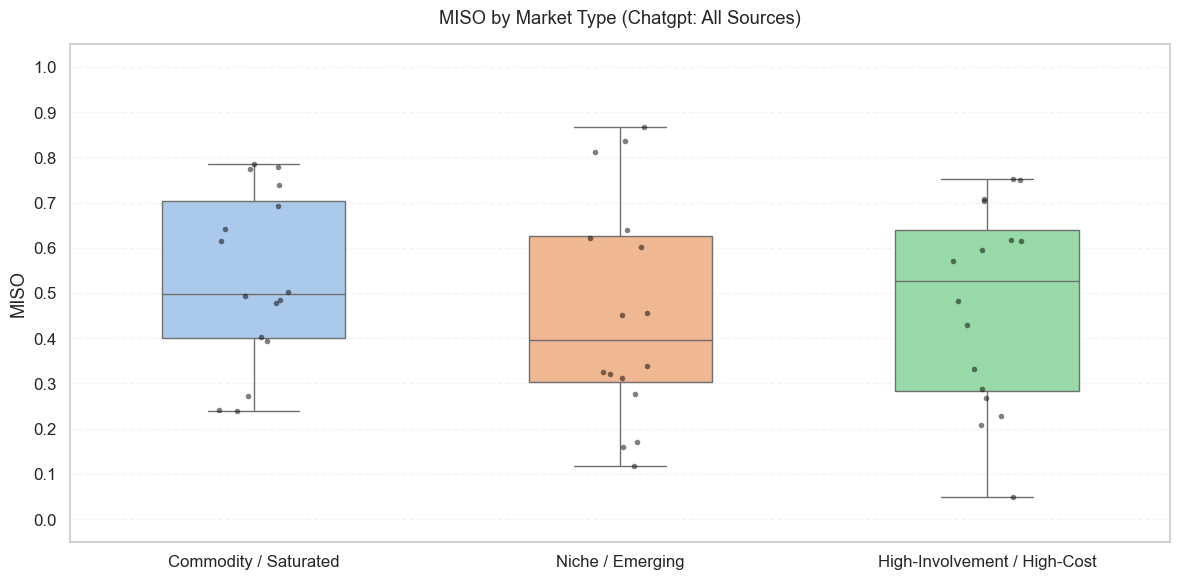

In [9]:
miso_cs_as = miso_df_as[miso_df_as["market_type"] == "Commodity / Saturated"]
miso_ne_as = miso_df_as[miso_df_as["market_type"] == "Niche / Emerging"]
miso_hh_as = miso_df_as[miso_df_as["market_type"] == "High-Involvement / High-Cost"]

plot_df_as = pd.DataFrame({
    "MISO": pd.concat([
        miso_cs_as["miso_mean"],
        miso_ne_as["miso_mean"],
        miso_hh_as["miso_mean"],
    ], ignore_index = True),
    "Market Type": (
        ["Commodity / Saturated"] * len(miso_cs_as)
        + ["Niche / Emerging"] * len(miso_ne_as)
        + ["High-Involvement / High-Cost"] * len(miso_hh_as)
    )
})

boxplot(
    df = plot_df_as,
    x_col = "Market Type",
    y_col = "MISO",
    order = ["Commodity / Saturated", "Niche / Emerging", "High-Involvement / High-Cost"],
    title = "MISO by Market Type (Chatgpt: All Sources)",
    xlabel = "",
    ylabel = "MISO"
)

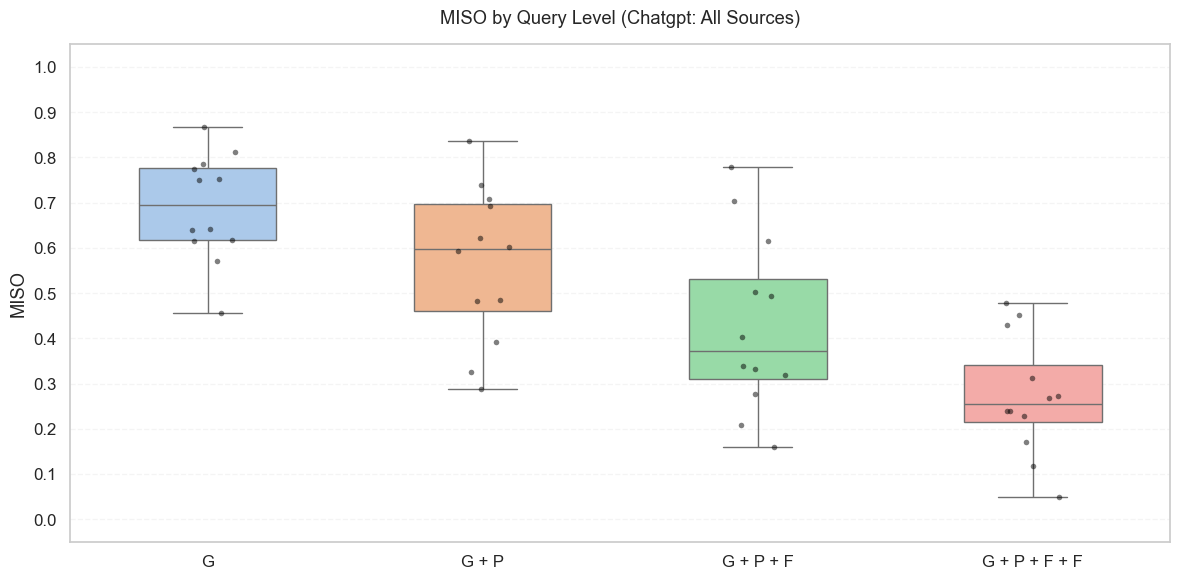

In [10]:
miso_g_as = miso_df_as[miso_df_as["query_level"] == "General"]
miso_gp_as = miso_df_as[miso_df_as["query_level"] == "General & Price"]
miso_gpf_as = miso_df_as[miso_df_as["query_level"] == "General & Price & Feature"]
miso_gpff_as = miso_df_as[miso_df_as["query_level"] == "General & Price & Feature & Feature"]

plot_df_as = pd.DataFrame({
    "MISO": pd.concat([
        miso_g_as["miso_mean"],
        miso_gp_as["miso_mean"],
        miso_gpf_as["miso_mean"],
        miso_gpff_as["miso_mean"]
    ], ignore_index = True),
    "Query Level": (
        ["G"] * len(miso_g_as)
        + ["G + P"] * len(miso_gp_as)
        + ["G + P + F"] * len(miso_gpf_as)
        + ["G + P + F + F"] * len(miso_gpff_as)
    )
})

boxplot(
    df = plot_df_as,
    x_col = "Query Level",
    y_col = "MISO",
    order = ["G", "G + P", "G + P + F", "G + P + F + F"],
    title = "MISO by Query Level (Chatgpt: All Sources)",
    xlabel = "",
    ylabel = "MISO"
)

<br />

<h4>Cross-Query Mean Internal Source Overlap (Allpairs) – Definition &amp; Implementation</h4> 

<p>To move beyond consistency within a single query, we extend the analysis across queries by defining the Cross-Query Mean Internal Source Overlap (CQMISO). This metric measures the overlap of ChatGPT’s <em>sources</em> between different queries, capturing patterns of overlap in the model’s sourcing behavior across topics.</p> 

<p> Formally, for each query \( q \), let the set of source lists generated by ChatGPT be \( S_{GPT_q} = [s_{q1}, s_{q2}, s_{q3}] \). To measure overlap between two distinct queries \( i \) and \( j \), we define: </p> 

<p> $$ CQMISO[i, j] = \frac{1}{|S_{GPT_i}|\,|S_{GPT_j}|} \sum_{u=1}^{|S_{GPT_i}|} \sum_{v=1}^{|S_{GPT_j}|} O_{\text{syntactic}}(s_{iu}, s_{jv}) $$ </p> 

<p> where \( O_{\text{semantic}}(s_{iu}, s_{jv}) \) denotes the semantic overlap between individual <em>source</em> lists \( s_{iu} \) and \( s_{jv} \). A higher CQMISO value indicates greater semantic consistency in the model’s source usage <em>across queries</em>. </p>

In [11]:
def calc_cqmiso_allpairs(chatgpt_df, source_col, overlap_function, filter_col = None):
    
    n = len(chatgpt_df)
    cqmiso_matrix = np.full((n, n), 0, dtype = float)
    source_lists = chatgpt_df[source_col].tolist()
    
    # filter
    filter_values = chatgpt_df[filter_col].tolist() if filter_col else [None] * n
    
    for i in tqdm(range(n), desc = f"Computing CQMIPO (filtered by {filter_col})", unit = "query"):
        for j in range(i, n):
            if filter_col and filter_values[i] != filter_values[j]:
                continue
            
            pairwise_overlaps = [
                overlap_function(a, b)
                for a in source_lists[i]
                for b in source_lists[j]
            ]
            cqmiso = np.mean(pairwise_overlaps) if pairwise_overlaps else np.nan
            cqmiso_matrix[i, j] = cqmiso
            cqmiso_matrix[j, i] = cqmiso
    
    return pd.DataFrame(cqmiso_matrix, index = chatgpt_df["query"], columns = chatgpt_df["query"])

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

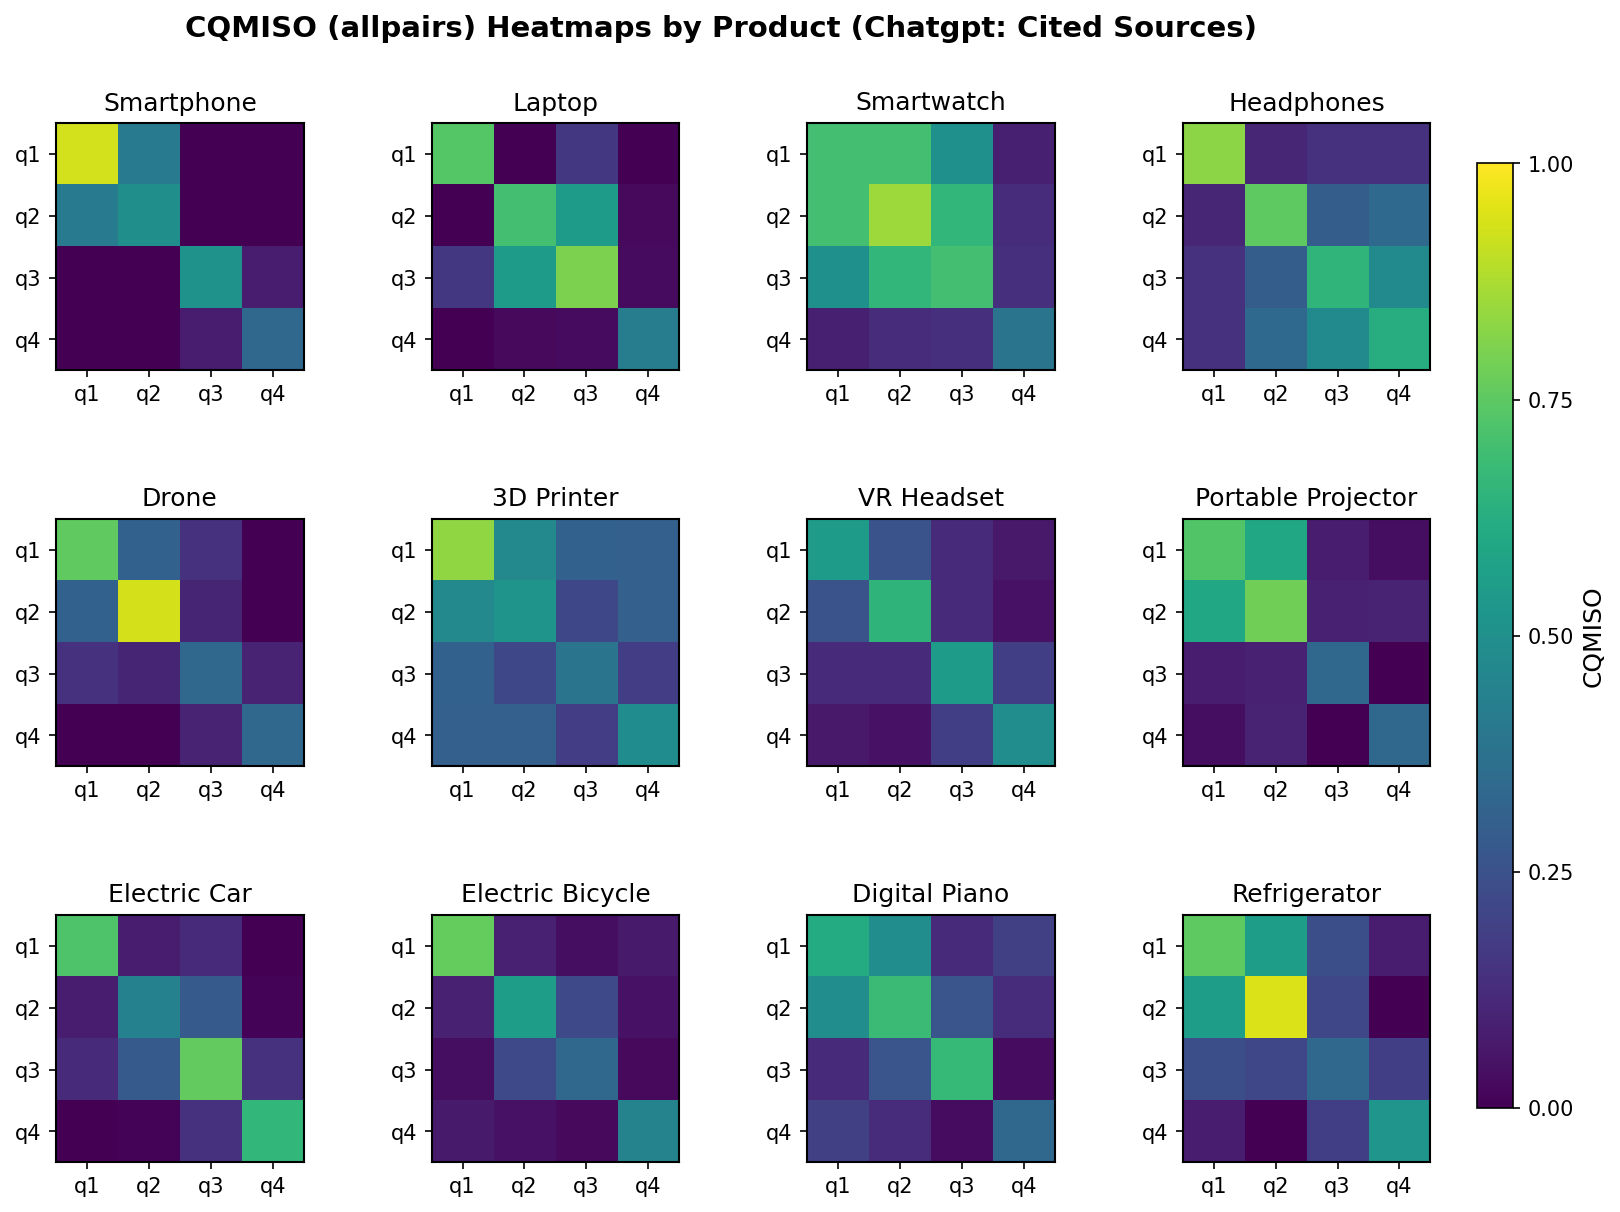

In [12]:
cqmiso_matrix_p_cs_a = calc_cqmiso_allpairs(chatgpt_df, source_col = "sources_cited", overlap_function = OVERLAP_FUNCTION, filter_col = "product")
heatmaps(cqmiso_matrix_p_cs_a, chatgpt_df, filter_col = "product", title = "CQMISO (allpairs) Heatmaps by Product (Chatgpt: Cited Sources)", colorbar_label = "CQMISO")

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

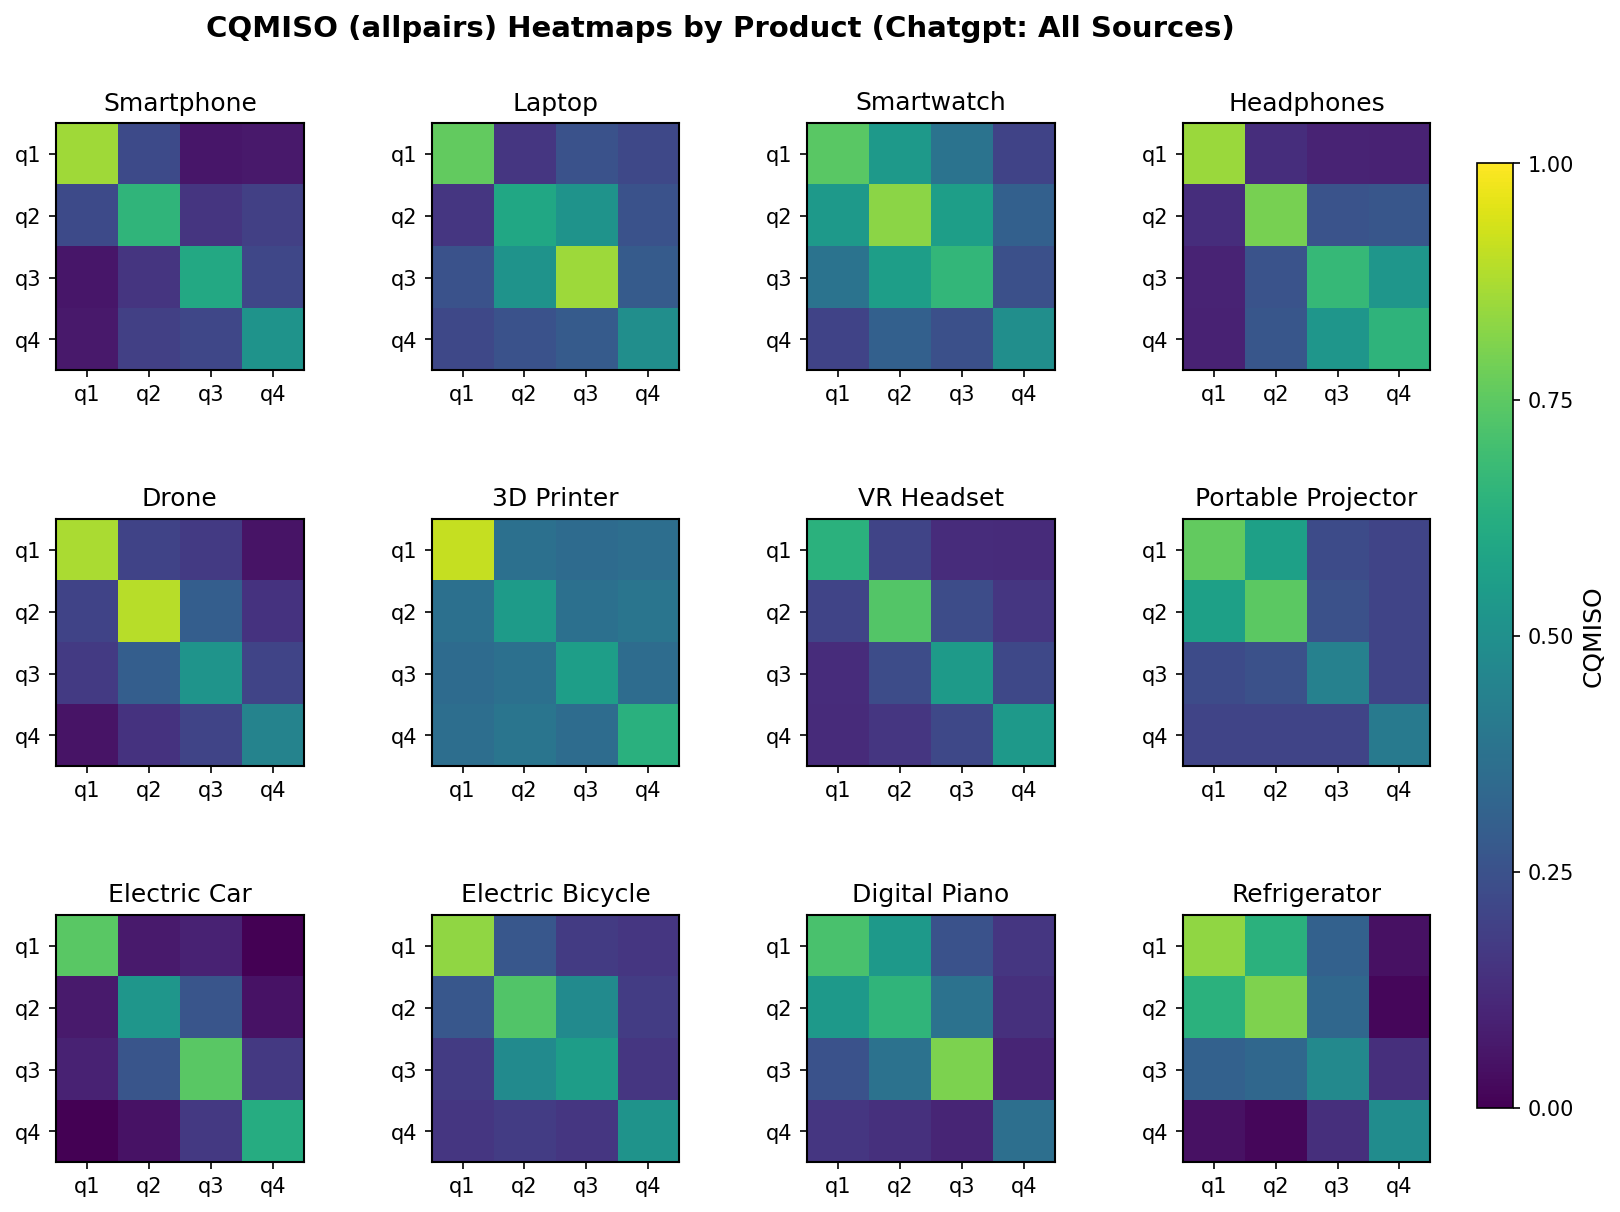

In [13]:
cqmiso_matrix_p_ca_a = calc_cqmiso_allpairs(chatgpt_df, source_col = "sources_all", overlap_function = OVERLAP_FUNCTION, filter_col = "product")
heatmaps(cqmiso_matrix_p_ca_a, chatgpt_df, filter_col = "product", title = "CQMISO (allpairs) Heatmaps by Product (Chatgpt: All Sources)", colorbar_label = "CQMISO")

<br />

<h4>Cross-Query Mean Internal Source Overlap (Positional) – Definition &amp; Implementation</h4> <p> To capture rank-sensitive consistency in source usage across queries, we define a positional variant of the Cross-Query Mean Internal Source Overlap (CQMISO). Unlike the all-pairs version, which considers every possible source comparison between two queries, the positional form focuses on how semantically similar sources are at the same ranked positions. This emphasizes alignment in ordering rather than mere content overlap. </p> <p> Formally, for each query $ q $, let the ranked list of sources retrieved or cited by ChatGPT be $ S_{GPT_q} = [s_{q1}, s_{q2}, \dots, s_{qK}] $. To measure positional overlap between two distinct queries $ i $ and $ j $, we define: </p> <p> $$ CQMISO_{\text{pos}}[i, j] = \frac{1}{K} \sum_{k=1}^{K} O_{\text{semantic}}(s_{ik}, s_{jk}) $$ </p> <p> where $ O_{\text{semantic}}(s_{ik}, s_{jk}) $ denotes the semantic overlap between the sources occupying the same rank $ k $ in queries $ i $ and $ j $. The value of $ K = \min(|S_{GPT_i}|, |S_{GPT_j}|) $ ensures comparisons are only made where both queries have valid source positions. A higher positional CQMISO value indicates greater rank-level consistency in ChatGPT’s source usage across queries—suggesting that the model preserves sourcing patterns even as query contexts vary. </p>

In [14]:
def calc_cqmiso_positional(chatgpt_df, source_col, overlap_function, filter_col = None):
    
    n = len(chatgpt_df)
    cqmiso_matrix = np.full((n, n), 0, dtype = float)
    source_lists = chatgpt_df[source_col].tolist()
    
    # filter
    filter_values = chatgpt_df[filter_col].tolist() if filter_col else [None] * n
    
    for i in tqdm(range(n), desc=f"Computing CQMIPO (filtered by {filter_col})", unit="query"):
        for j in range(i, n):
            if filter_col and filter_values[i] != filter_values[j]:
                continue
            
            # Compare l1 with l1, l2 with l2, l3 with l3
            position_overlaps = []
            for k in range(min(len(source_lists[i]), len(source_lists[j]))):
                overlap = syntactic_overlap(source_lists[i][k], source_lists[j][k])
                position_overlaps.append(overlap)
            
            # Mean across positions
            cqmiso = np.mean(position_overlaps) if position_overlaps else np.nan
            cqmiso_matrix[i, j] = cqmiso
            cqmiso_matrix[j, i] = cqmiso
    
    return pd.DataFrame(cqmiso_matrix, index=chatgpt_df["query"], columns=chatgpt_df["query"])

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

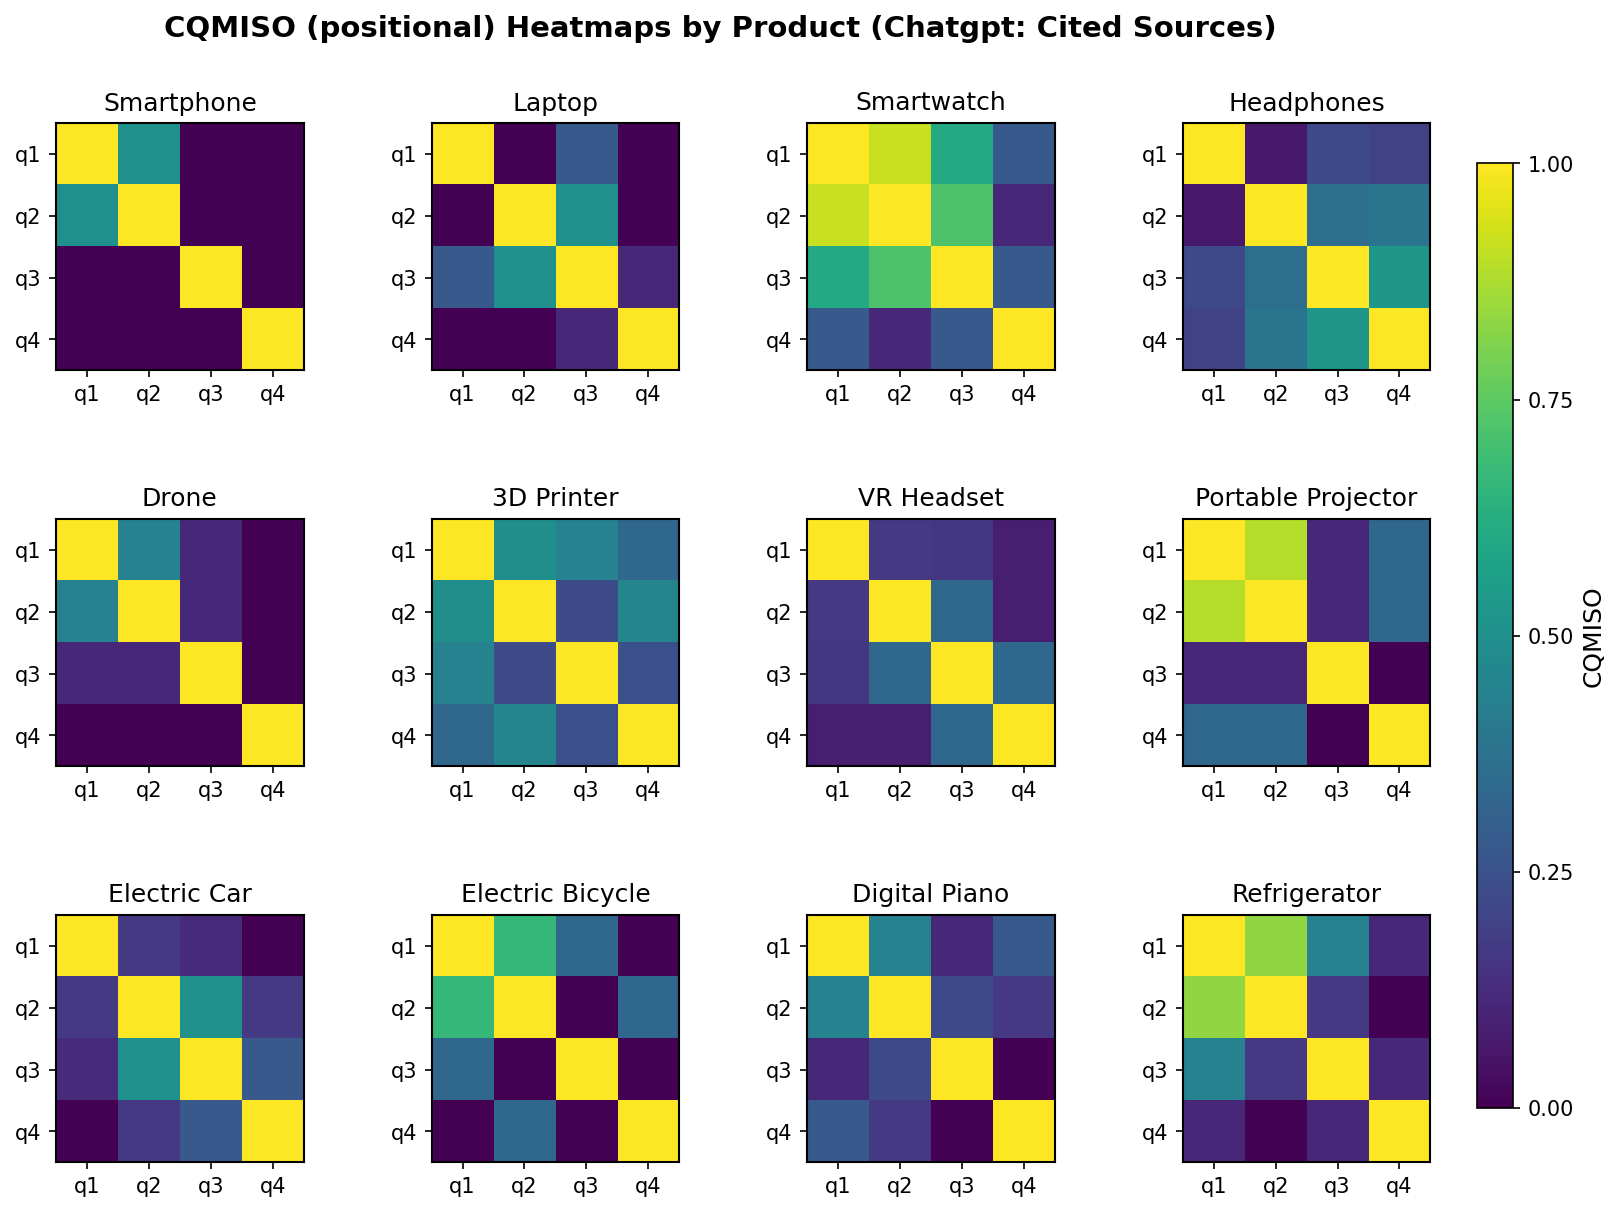

In [15]:
cqmiso_matrix_p_cs_p = calc_cqmiso_positional(chatgpt_df, source_col = "sources_cited", overlap_function = OVERLAP_FUNCTION, filter_col = "product")
heatmaps(cqmiso_matrix_p_cs_p, chatgpt_df, filter_col = "product", title = "CQMISO (positional) Heatmaps by Product (Chatgpt: Cited Sources)", colorbar_label = "CQMISO")

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

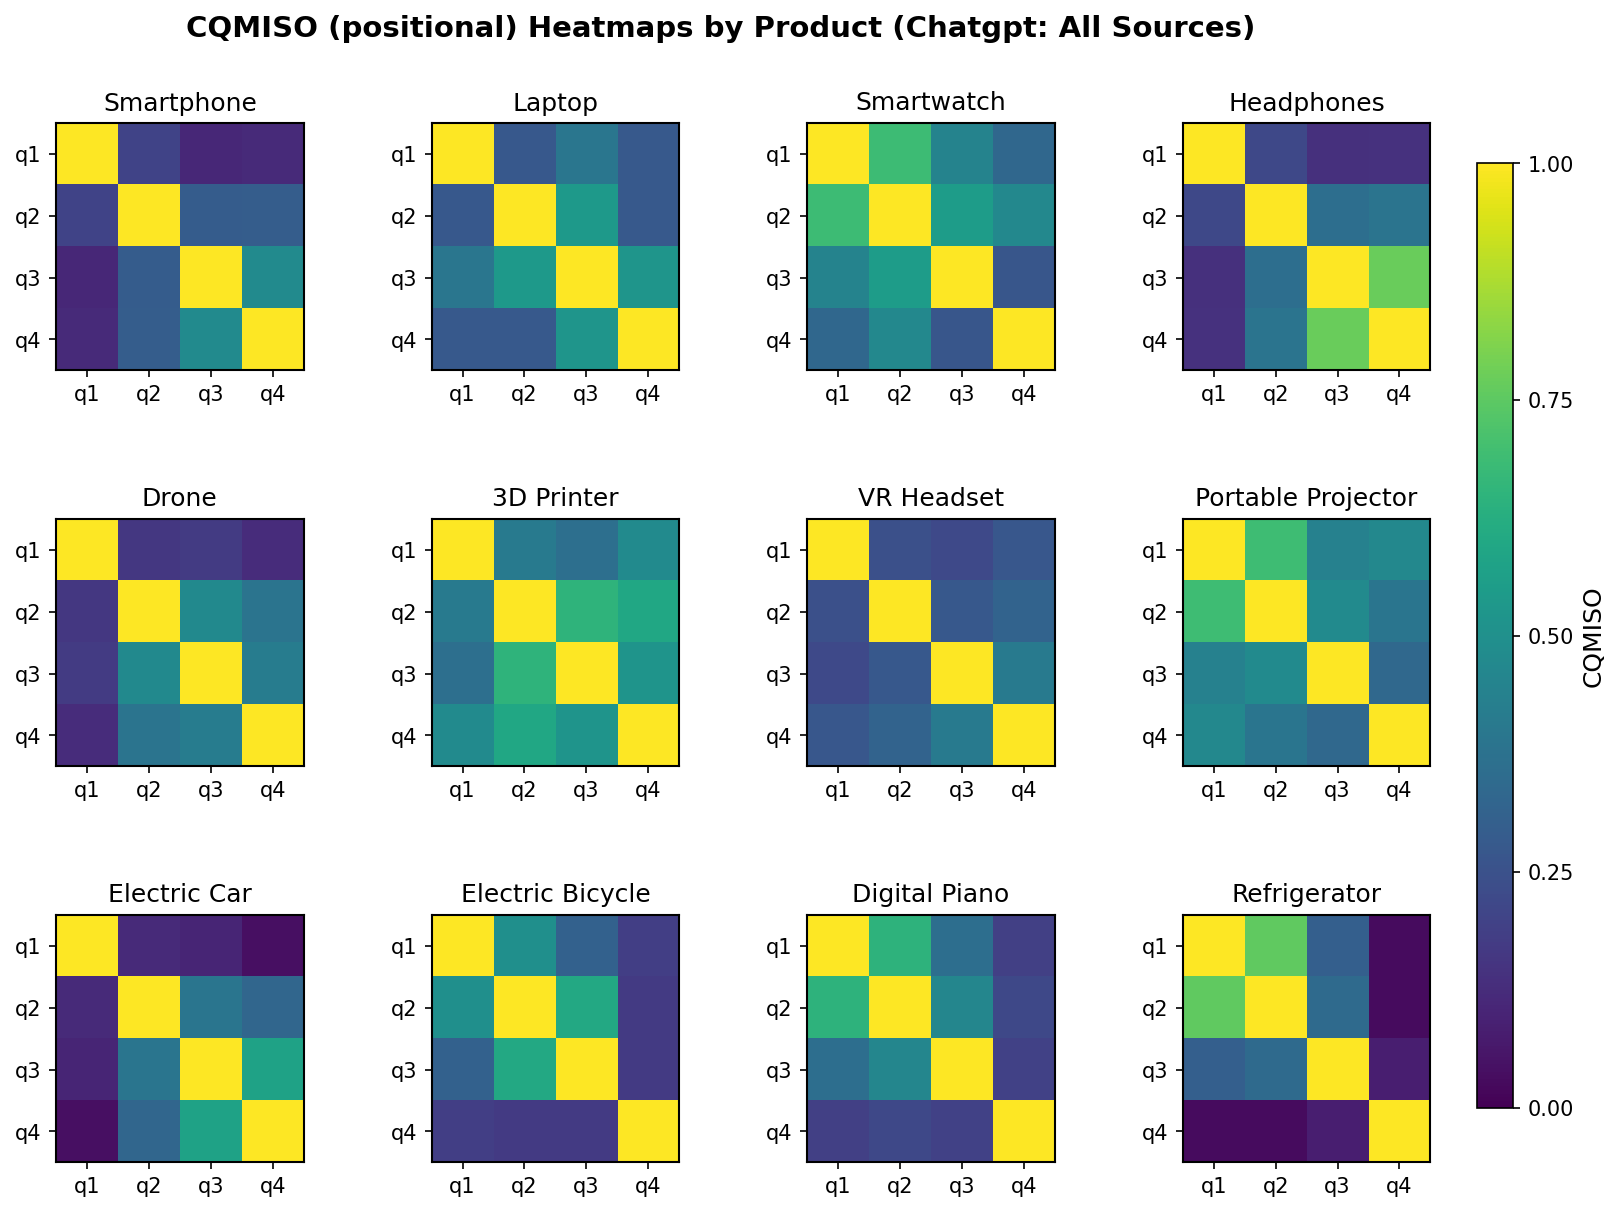

In [16]:
cqmiso_matrix_p_ca_p = calc_cqmiso_positional(chatgpt_df, source_col = "sources_all", overlap_function = OVERLAP_FUNCTION, filter_col = "product")
heatmaps(cqmiso_matrix_p_ca_p, chatgpt_df, filter_col = "product", title = "CQMISO (positional) Heatmaps by Product (Chatgpt: All Sources)", colorbar_label = "CQMISO")